In [1]:
import numpy as np
import numpy.random as random
import scipy as sp
import scipy.stats as stats
import pandas as pd
from pandas import Series, DataFrame

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
%precision 3

'%.3f'

In [2]:
Odata=pd.read_csv('hn18.csv', low_memory=False)
Odata
Odata.head(5)

mod_d          ID    ID_fam  year  region  town_t  apt_t   psu  sex  \
0  2020.09.01.  A901020501  A9010205  2018       1       1      2  A901    1   
1  2020.09.01.  A901021301  A9010213  2018       1       1      2  A901    1   
2  2020.09.01.  A901021302  A9010213  2018       1       1      2  A901    2   
3  2020.09.01.  A901022601  A9010226  2018       1       1      2  A901    2   
4  2020.09.01.  A901023303  A9010233  2018       1       1      2  A901    2   

   age  ...  HEI_TVEG   HEI_VEG  HEI_PROTF  HEI_DAIRY    HEI_SFA     HEI_NA  \
0   80  ...  1.367163  0.775022   5.800000        0.0   5.273475  10.000000   
1   78  ...  4.881043  1.641812  10.000000       10.0  10.000000   3.418798   
2   75  ...  3.367648  4.943629   4.849725       10.0   0.000000   9.806158   
3   43  ...       NaN       NaN        NaN        NaN        NaN        NaN   
4   80  ...  4.619405  0.437024   1.951565        0.0  10.000000   8.029505   

   HEI_SWEET   HEI_CHO   HEI_FAT    HEI_EN  
0       10.0  5.000000  5.000000  0.000000  
1       10.0  4.345249  2.956568  5.000000  
2       10.0  5.000000  5.000000  5.000000  
3        NaN       NaN       NaN       NaN  
4       10.0  0.000000  0.000000  1.244134  

[5 rows x 785 columns]

# 전체 데이터에서 필요한 열만 가져오고 가져온 응답을 진단, 정상으로 바꾸고 물 섭취량의 경우 구간에 따라 level을 나눔

In [68]:
data=pd.DataFrame()
data['ID']=Odata.ID
data['sex']=Odata.sex
data['age']=Odata.age
data['water']=Odata.N_WAT_C
data['BMI']=Odata.HE_BMI
data['BMI2']=Odata.HE_obe
data['협심증응답']=Odata.DI6_pr
data['심근경색응답']=Odata.DI5_pr
data['고혈압응답']=Odata.DI1_pr
data['신부전응답']=Odata.DN1_pr
data['당뇨응답']=Odata.DE1_pr
data['Health']=Odata.D_1_1
data['와병여부']=Odata.D_1_1
data.dropna(inplace=True, axis=0)
data=data[data['Health']!=9]
data=data[data['와병여부']!=1]
data['AP']=np.where(data['협심증응답']==1, 1, 0)
data['MI']=np.where(data['심근경색응답']==1, 1, 0)
data['HBP']=np.where(data['고혈압응답']==1, 1, 0)
data['KF']=np.where(data['신부전응답']==1, 1, 0)
data['D']=np.where(data['당뇨응답']==1, 1, 0)
data['waterLv']=pd.cut(data.water, [0, 2.5, 5, 10, 999], labels=[1,2,3, 4], right=False)

In [69]:
data.head(5)

ID  sex  age  water        BMI  BMI2  협심증응답  심근경색응답  고혈압응답  신부전응답  \
0  A901020501    1   80    5.0  21.233226   2.0    8.0     8.0    1.0    8.0   
2  A901021302    2   75    5.0  21.391845   2.0    8.0     8.0    1.0    8.0   
5  A901023304    2   71   10.0  21.528142   2.0    8.0     8.0    1.0    8.0   
6  A901023501    1   44    2.0  26.419753   4.0    8.0     8.0    8.0    8.0   
7  A901023502    2   42    2.0  19.021922   2.0    8.0     8.0    8.0    8.0   

   당뇨응답  Health  와병여부  AP  MI  HBP  KF  D waterLv  
0   8.0     3.0   3.0   0   0    1   0  0       3  
2   8.0     3.0   3.0   0   0    1   0  0       3  
5   1.0     3.0   3.0   0   0    1   0  1       4  
6   8.0     4.0   4.0   0   0    0   0  0       1  
7   8.0     2.0   2.0   0   0    0   0  0       1

In [125]:
pd.value_counts(data.waterLv)

3    2094
2    1541
1     733
4     591
Name: waterLv, dtype: int64

In [124]:
data.water.unique()

array([ 5. , 10. ,  2. ,  4. , 15. , 12. ,  7. ,  3. ,  5.5,  7.5,  8. ,
        2.5,  1. ,  0.5,  1.5,  6.5,  6. ,  5.7,  3.5,  4.2, 30. ,  7.7,
        3.4,  1.2,  3.8,  4.5, 12.5,  2.3,  3.7,  6.3,  6.4,  0.8, 20. ,
        4.6, 14.3,  9. , 25. , 11. , 13. ,  2.4,  0.7,  8.5, 22.5,  6.1,
        3.1,  0. , 17. , 15.8,  4.8,  6.8,  1.3,  5.3, 16.3,  7.9,  6.2,
        0.3, 13.3, 14. ,  3.6,  6.7, 17.5,  2.7,  0.2,  5.6, 11.3,  9.8,
        2.6,  4.3,  4.4,  5.2,  8.7,  8.8,  7.2,  2.2,  1.7, 15.5,  1.8,
       11.4,  7.8,  3.2,  5.4, 18. ,  9.1,  7.3, 11.5,  2.8,  8.6,  9.2,
        1.9])

array([[1.   , 0.111],
       [0.111, 1.   ]])

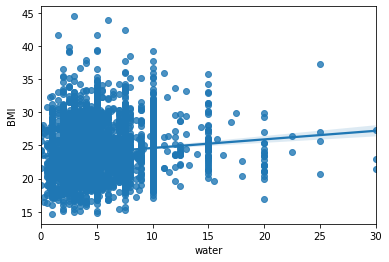

In [71]:
sns.regplot(data = data, x = 'water', y = 'BMI')
np.corrcoef(data.water, data.BMI)

waterLv
1    23.334344
2    23.706007
3    24.193912
4    24.728733
Name: BMI, dtype: float64


Text(0.5, 1.0, 'BMI')

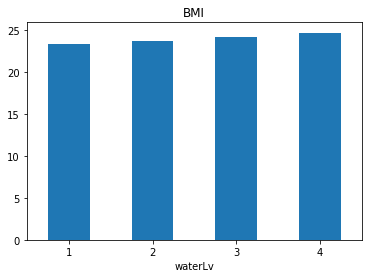

In [89]:
df=data.groupby('waterLv').mean()
print(df.BMI)
df.BMI.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('BMI')

## 체중에 따라 물 섭취량이 비례함을 알 수 있다.

waterLv
1    0.012278
2    0.024659
3    0.022445
4    0.010152
Name: AP, dtype: float64


[0.1460864285265572, 0.8838591000822213]

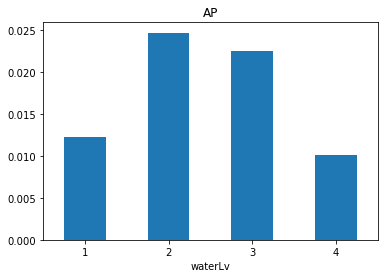

In [105]:
print(df.AP)
df.AP.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('AP')
[t_stat, p] = stats.ttest_ind(data[data.AP==0].waterLv, data[data.AP==1].waterLv)
[t_stat, p]

waterLv
1    0.009550
2    0.014925
3    0.010506
4    0.005076
Name: MI, dtype: float64


[1.1032902899590324, 0.26995467946564555]

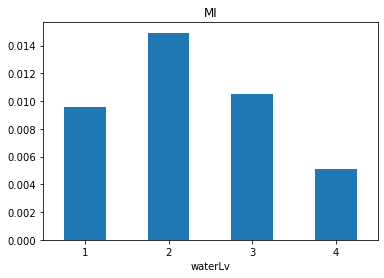

In [103]:
print(df.MI)
df.MI.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('MI')
[t_stat, p] = stats.ttest_ind(data[data.MI==0].waterLv, data[data.MI==1].waterLv)
[t_stat, p]

waterLv
1    0.005457
2    0.001298
3    0.002865
4    0.001692
Name: KF, dtype: float64


[0.8363163047366612, 0.40301729515556806]

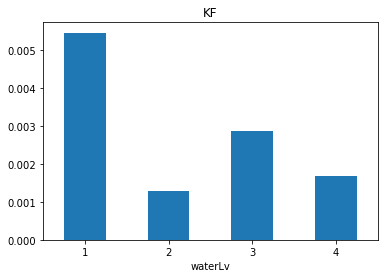

In [128]:
print(df.KF)
df.KF.plot(kind='bar')
plt.title('KF')
plt.xticks(rotation=0)
[t_stat, p] = stats.ttest_ind(data[data.KF==0].waterLv, data[data.KF==1].waterLv)
[t_stat, p]

In [126]:
print(df.D)

waterLv
1    0.090041
2    0.109020
3    0.095511
4    0.082910
Name: D, dtype: float64


[0.8483891525357476, 0.3962622465772798]

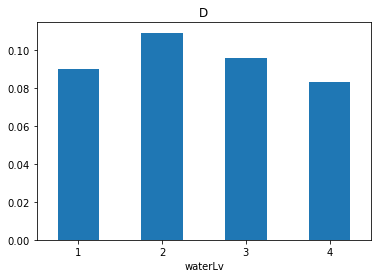

In [127]:
df.D.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('D')
[t_stat, p] = stats.ttest_ind(data[data.D==0].waterLv, data[data.D==1].waterLv)
[t_stat, p]

In [122]:
print(df.HBP)

waterLv
1    0.226467
2    0.278391
3    0.236867
4    0.196277
Name: HBP, dtype: float64


[2.1293789892648043, 0.03327205845316419]

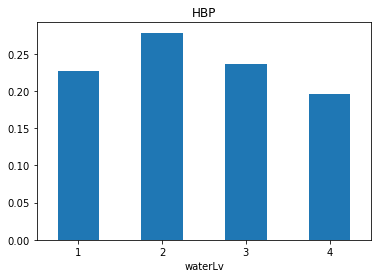

In [116]:
df.HBP.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('HBP')
[t_stat, p] = stats.ttest_ind(data[data.HBP==0].waterLv, data[data.HBP==1].waterLv)
[t_stat, p]

## 고혈압과 waterLv사이의 유의확률이 낮기 때문에 고혈압과 물 섭취량이 연관 되어있음을 알 수 있다.

### https://m.health.chosun.com/column/column_view.jsp?idx=877
### https://m.health.chosun.com/svc/news_view.html?contid=2021031002245 
### 혈압이 높으면 물을 많이 마셔야 한다는 기사를 찾을 수 있다.
### 탈수상태가 되면 모세혈관의 일부가 닫히고 혈압이 높아질 수 있다고 한다. 또한 체내 수분이 부족해져 혈전이 생기는 것을 줄일 수 있다고 한다.

## 번외) 주관적인 건강과 물섭취

waterLv
1    3.053206
2    3.042829
3    2.979465
4    2.888325
Name: Health, dtype: float64


Text(0.5, 1.0, 'Health')

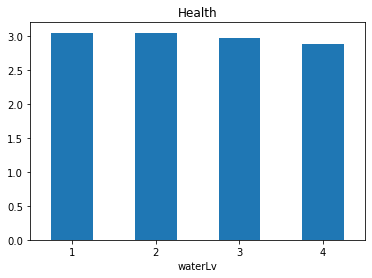

In [130]:
print(df.Health)
df.Health.plot(kind='bar')
plt.xticks(rotation=0)
plt.title('Health')

In [131]:
np.corrcoef(data.waterLv, data.Health)

array([[ 1.   , -0.062],
       [-0.062,  1.   ]])

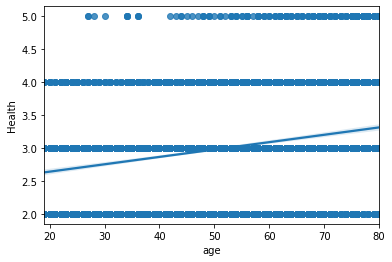

In [134]:
sns.regplot(data = data, x = 'age', y = 'Health')

In [135]:
np.corrcoef(data.age, data.Health)

array([[1.   , 0.242],
       [0.242, 1.   ]])

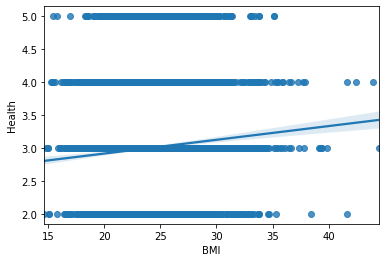

In [136]:
sns.regplot(data = data, x = 'BMI', y = 'Health')

In [137]:
np.corrcoef(data.BMI, data.Health)

array([[1.   , 0.096],
       [0.096, 1.   ]])

array([[1.   , 0.109],
       [0.109, 1.   ]])

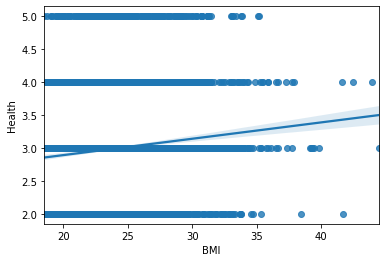

In [138]:
sns.regplot(data = data[data.BMI>=18.5], x = 'BMI', y = 'Health')
np.corrcoef(data[data.BMI>=18.5].BMI, data[data.BMI>=18.5].Health)

array([[1.   , 0.118],
       [0.118, 1.   ]])

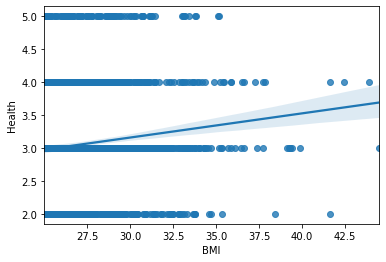

In [139]:
sns.regplot(data = data[data.BMI>=25], x = 'BMI', y = 'Health')
np.corrcoef(data[data.BMI>=25].BMI, data[data.BMI>=25].Health)

array([[1.   , 0.023],
       [0.023, 1.   ]])

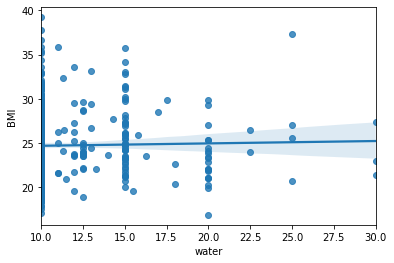

In [140]:
sns.regplot(data = data[data.water>=10], x = 'water', y = 'BMI')
np.corrcoef(data[data.water>=10].water, data[data.water>=10].BMI)

array([[1.   , 0.028],
       [0.028, 1.   ]])

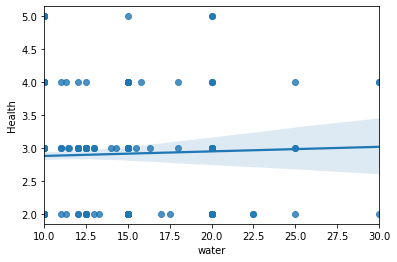

In [141]:
sns.regplot(data = data[data.water>=10], x = 'water', y = 'Health')
np.corrcoef(data[data.water>=10].water, data[data.water>=10].Health)

## 젊은 사람들이 당연히 건강하다고 생각하고 BMI와 관련 없이 큰 질병이 없다면 건강하다고 느끼는 것을 알 수 있다